## Import packages

In [1]:
# Import library
from detection_testing.utils.FloorplanToBlenderLib import *
from matplotlib import pyplot as plt
import cv2 # for image gathering
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
import pytesseract
import easyocr
# pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files (x86)\\Tesseract-OCR\\tesseract.exe'
from PIL import Image
from IPython.display import display
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

C:\Users\Student\anaconda3\envs\python_course\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## import module

In [2]:
reader = easyocr.Reader(['ch_tra','en']) # this needs to run only once to load the model into memory

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\Student\anaconda3\envs\python_course\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
C:\Users\Student\anaconda3\envs\python_course\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Student\anaconda3\envs\python_course\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


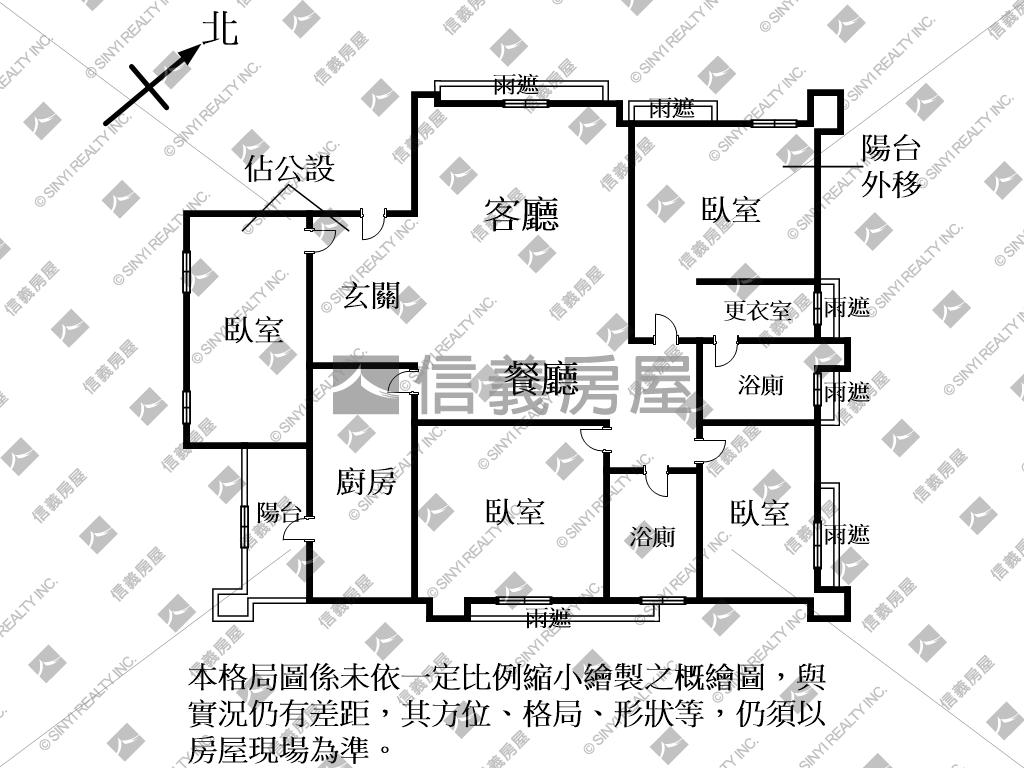

In [3]:
img = cv2.imread('detection_testing/Images/test1.jpg')
#print(type(img))

display(Image.fromarray(img))

#im_show = Image.fromarray(img)
#im_show.show()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## Image Process

In [4]:
def remove_noise(img):
    # get binary image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to gray
    thresh = cv2.threshold(img_gray, 135, 255, cv2.THRESH_BINARY)[1] # convert to binary
    img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    # contour hierarchy
    regions, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # detect all elements
    countour_list = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        countour_list.append([x, y, w, h])
    
    # get 2nd largest contour
    countour_list = np.asarray(countour_list)  # convert to numpy-array
    column_values = ['left', 'top', 'width', 'height']
    df = pd.DataFrame(data = countour_list, columns = column_values)
    df = df.sort_values(by='width', ascending=False)

    index = df.iloc[1]
    x, y, w, h = index['left'], index['top'], index['width'], index['height']

    
    # remove outside noise
    img[:, :x] = [255, 255, 255]
    img[x + w + 1:, :] = [255, 255, 255]
    img[:y, :] = [255, 255, 255]
    img[y + h + 1:, :] = [255, 255, 255]
    
    # paint rectangle
    #cv2.rectangle(img,(x,y), (x+w, y+h), (255,0,0)) 
    #img = cv2.rectangle(img,(x,y), (x+w, y+h), (255,0,0))
    
    return img

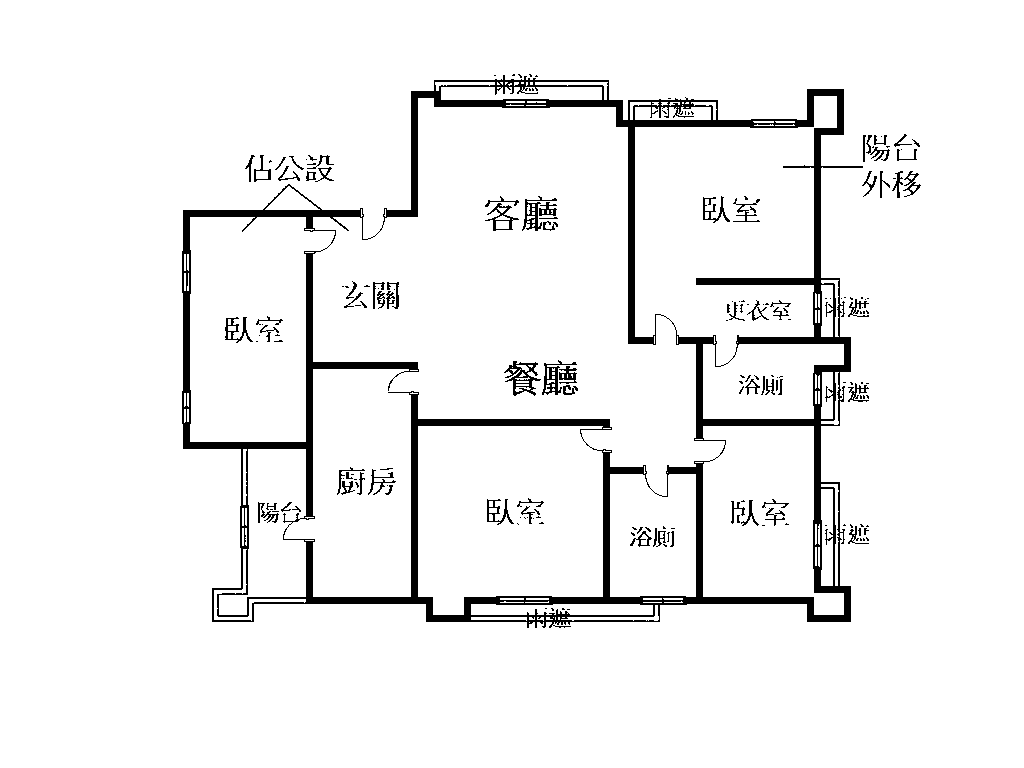

In [5]:
img = remove_noise(img)
display(Image.fromarray(img))

## Text Recognition

In [6]:
def impl_model(img):
    # get words position
    result = reader.readtext(img,
                             detail=1,
                             paragraph=True, # Combine result into paragraph
                             x_ths=0.1, # Maximum horizontal distance to merge text boxes when paragraph=True
                             y_ths=0.5, # Maximum verticall distance to merge text boxes when paragraph=True
                             # width_ths=0.1,
                             # height_ths=0.1,
                             mag_ratio=1.2,
                             )
    return result

In [7]:
result = impl_model(img)
result

[[[[857, 128], [923, 128], [923, 201], [857, 201]], '陽口 外移'],
 [[[238, 148], [338, 148], [338, 188], [238, 188]], '佔公設'],
 [[[479, 191], [564, 191], [564, 239], [479, 239]], '客廳'],
 [[[697, 190], [763, 190], [763, 228], [697, 228]], '臥室'],
 [[[337, 277], [401, 277], [401, 314], [337, 314]], '么關'],
 [[[721, 296], [795, 296], [795, 325], [721, 325]], '史花室'],
 [[[821, 294], [872, 294], [872, 320], [821, 320]], '廓遮'],
 [[[218, 310], [288, 310], [288, 348], [218, 348]], '臥室'],
 [[[497, 354], [584, 354], [584, 402], [497, 402]], '餐廳'],
 [[[734, 371], [788, 371], [788, 398], [734, 398]], '浴廁'],
 [[[332, 462], [399, 462], [399, 501], [332, 501]], '廚房'],
 [[[254, 496], [307, 496], [307, 528], [254, 528]], '陽&'],
 [[[480, 492], [548, 492], [548, 529], [480, 529]], '臥室'],
 [[[723, 493], [793, 493], [793, 531], [723, 531]], '臥室'],
 [[[628, 523], [678, 523], [678, 552], [628, 552]], '浴廁']]

In [8]:
def correct_name(result):
    # correct to the right room name
    bed_room = ['堅', '臥 室', '臥 堂', '室', '臥室']
    bth_room = ['瑜', '}', '沿廁', '浴廁','淞廁','汗廝','洽刪']
    d_room = ['餐廳']
    l_room = ['客廳']
    kit = ['麝','房', '廚房']
    bal=['陽=','陽^','陽台']
    for i in range(len(result)): 

        if result [i][-1] in bed_room: result [i][-1] = '臥室' # bedroom

        elif result [i][-1] in bth_room: result [i][-1] = '浴廁' # bathroom

        elif result [i][-1] in d_room: result [i][-1] = '餐廳' # dining room

        elif result [i][-1] in l_room: result [i][-1] = '客廳' # living room

        elif result [i][-1] in kit: result [i][-1] = '廚房' # kitchen

        elif result [i][-1] in bal: result [i][-1] = '陽台' # kitchen

        else: result [i][-1] = '其他' # others

    return result

In [9]:
c_n_result = correct_name(result)
c_n_result

[[[[857, 128], [923, 128], [923, 201], [857, 201]], '其他'],
 [[[238, 148], [338, 148], [338, 188], [238, 188]], '其他'],
 [[[479, 191], [564, 191], [564, 239], [479, 239]], '客廳'],
 [[[697, 190], [763, 190], [763, 228], [697, 228]], '臥室'],
 [[[337, 277], [401, 277], [401, 314], [337, 314]], '其他'],
 [[[721, 296], [795, 296], [795, 325], [721, 325]], '其他'],
 [[[821, 294], [872, 294], [872, 320], [821, 320]], '其他'],
 [[[218, 310], [288, 310], [288, 348], [218, 348]], '臥室'],
 [[[497, 354], [584, 354], [584, 402], [497, 402]], '餐廳'],
 [[[734, 371], [788, 371], [788, 398], [734, 398]], '浴廁'],
 [[[332, 462], [399, 462], [399, 501], [332, 501]], '廚房'],
 [[[254, 496], [307, 496], [307, 528], [254, 528]], '其他'],
 [[[480, 492], [548, 492], [548, 529], [480, 529]], '臥室'],
 [[[723, 493], [793, 493], [793, 531], [723, 531]], '臥室'],
 [[[628, 523], [678, 523], [678, 552], [628, 552]], '浴廁']]

## Get Words Position

In [10]:
def get_words_position():
    c_list = []
    
    # length = len(result)
    for i in c_n_result:
        # img_array.append(i[0]) 
        # room_name.append(i[1]) # get room type array
        
        # get center of each word
        x = (i[0][1][1] + i[0][2][1]) / 2  # gey x
        y = (i[0][0][0] + i[0][1][0]) / 2  # get y
        
        # put in center of gravity list
        c_list.append([[y, x], i[1]])

    return c_list

In [11]:
c_list = get_words_position()
c_list

[[[890.0, 164.5], '其他'],
 [[288.0, 168.0], '其他'],
 [[521.5, 215.0], '客廳'],
 [[730.0, 209.0], '臥室'],
 [[369.0, 295.5], '其他'],
 [[758.0, 310.5], '其他'],
 [[846.5, 307.0], '其他'],
 [[253.0, 329.0], '臥室'],
 [[540.5, 378.0], '餐廳'],
 [[761.0, 384.5], '浴廁'],
 [[365.5, 481.5], '廚房'],
 [[280.5, 512.0], '其他'],
 [[514.0, 510.5], '臥室'],
 [[758.0, 512.0], '臥室'],
 [[653.0, 537.5], '浴廁']]

## Create rectangle

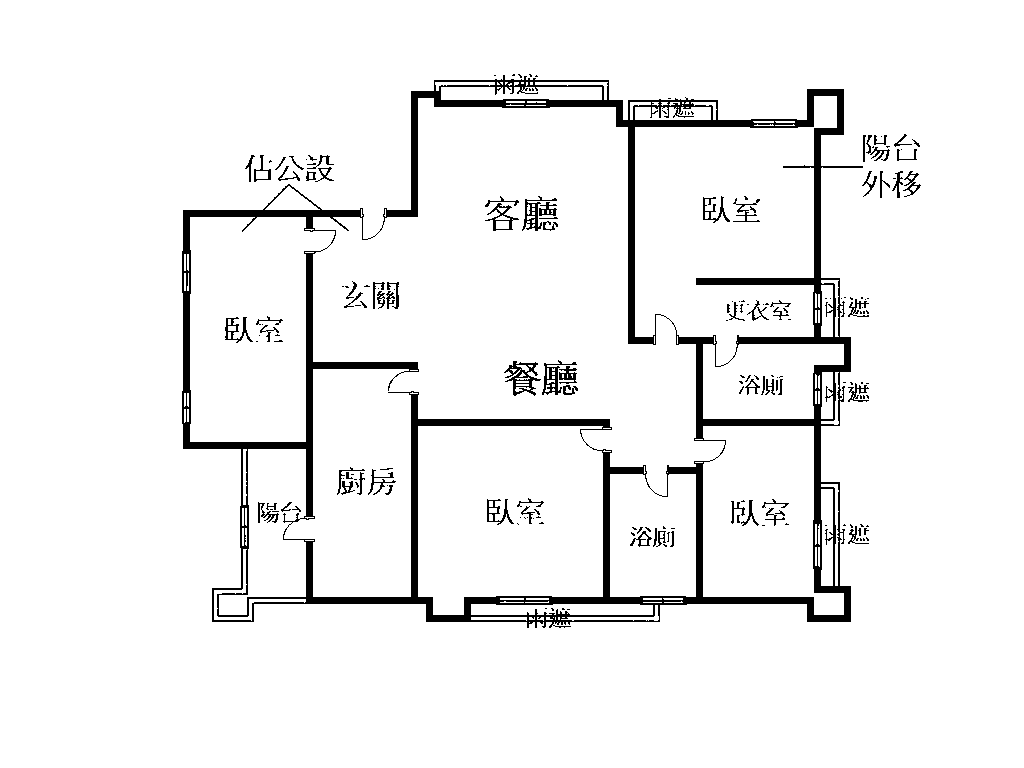

In [12]:
test = img.copy()
display(Image.fromarray(test))

[[857, 128], [923, 128], [923, 201], [857, 201]] ==> 其他
[[238, 148], [338, 148], [338, 188], [238, 188]] ==> 其他
[[479, 191], [564, 191], [564, 239], [479, 239]] ==> 客廳
[[697, 190], [763, 190], [763, 228], [697, 228]] ==> 臥室
[[337, 277], [401, 277], [401, 314], [337, 314]] ==> 其他
[[721, 296], [795, 296], [795, 325], [721, 325]] ==> 其他
[[821, 294], [872, 294], [872, 320], [821, 320]] ==> 其他
[[218, 310], [288, 310], [288, 348], [218, 348]] ==> 臥室
[[497, 354], [584, 354], [584, 402], [497, 402]] ==> 餐廳
[[734, 371], [788, 371], [788, 398], [734, 398]] ==> 浴廁
[[332, 462], [399, 462], [399, 501], [332, 501]] ==> 廚房
[[254, 496], [307, 496], [307, 528], [254, 528]] ==> 其他
[[480, 492], [548, 492], [548, 529], [480, 529]] ==> 臥室
[[723, 493], [793, 493], [793, 531], [723, 531]] ==> 臥室
[[628, 523], [678, 523], [678, 552], [628, 552]] ==> 浴廁


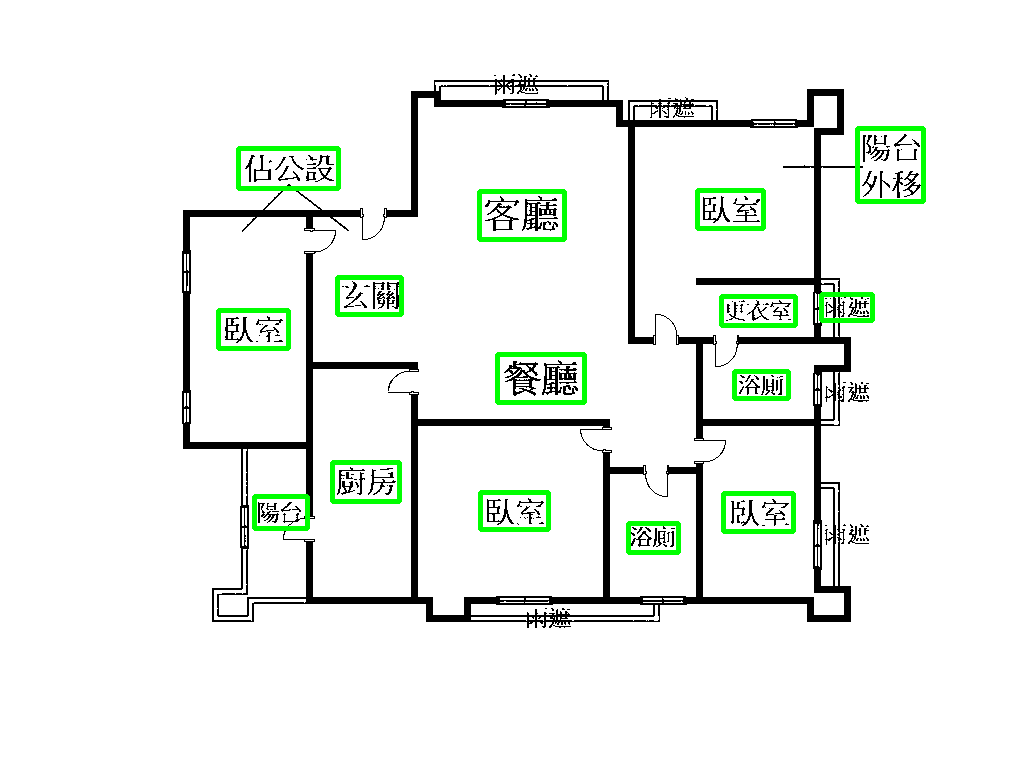

In [13]:
for i in c_n_result:
    
    p1x = round(i[0][0][0])
    p1y = round(i[0][0][1])
    p2x = round(i[0][2][0])
    p2y = round(i[0][2][1])
    #cv2.rectangle(test, (p1x, p1y), (p2x, p2y), (0,255,0),3)
    cv2.rectangle(test, (p1x, p1y), (p2x, p2y), (0,255,0),3)
    
    # cx = round(i[0][0])
    # cy = round(i[0][1])
    # cv2.circle(test,(cx,cy), 10, (0,0,255), -1)
    
    print(f'{i[0]} ==> {i[1]}')

display(Image.fromarray(test))

## Get Boxes & Room list

In [14]:
def get_boxes(img):
    # get boxes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = detect.wall_filter(gray)

    gray = ~gray

    rooms, colored_rooms = detect.find_rooms(gray.copy())

    gray_rooms =  cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

    # get box positions for rooms
    boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
    
    return boxes, gray_rooms

In [15]:
def get_room_list(img, c_list):
    room_list = []
    
    boxes, gray = get_boxes(img)
    
    for i in boxes:
        new_arr = np.reshape(np.ravel(i), (-1, 2)) # equivalent to C ravel then C reshape
        box = new_arr.tolist() # convert to python scalar

        polygon = Polygon(box)

        for j in c_list:
            point = Point(j[0])
            if polygon.contains(point):
                room_list.append([box, j[1]])
    
    return room_list

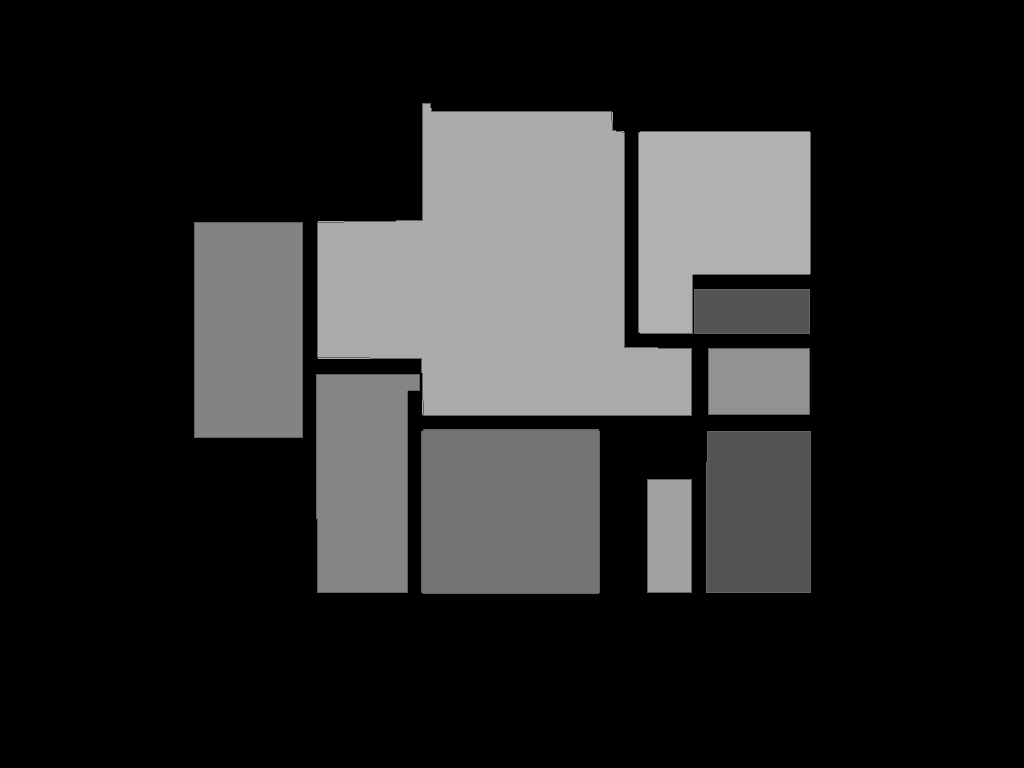

[[[647, 479], [647, 592], [691, 592], [691, 479]], '浴廁']
[[[707, 431], [707, 461], [706, 462], [706, 592], [810, 592], [810, 431]], '臥室']
[[[421, 431], [421, 592], [423, 593], [598, 593], [599, 592], [599, 431], [598, 429], [423, 429], [423, 430]], '臥室']
[[[316, 374], [316, 518], [317, 519], [317, 592], [407, 592], [407, 391], [408, 390], [419, 390], [419, 374]], '廚房']
[[[708, 348], [708, 414], [809, 414], [809, 348]], '浴廁']
[[[694, 289], [694, 333], [809, 333], [809, 289]], '其他']
[[[194, 222], [194, 437], [302, 437], [302, 222]], '臥室']
[[[638, 132], [638, 332], [640, 333], [692, 333], [692, 275], [693, 274], [809, 274], [810, 273], [810, 132], [809, 131], [640, 131]], '臥室']
[[[317, 222], [317, 357], [421, 358], [423, 415], [691, 415], [691, 348], [624, 347], [624, 132], [612, 130], [611, 111], [431, 111], [430, 103], [422, 103], [422, 220]], '客廳']
[[[317, 222], [317, 357], [421, 358], [423, 415], [691, 415], [691, 348], [624, 347], [624, 132], [612, 130], [611, 111], [431, 111], [430,

In [16]:
boxes, gray_rooms = get_boxes(img)


display(Image.fromarray(gray_rooms))
# print(boxes)


#n = len(boxes)
#print(n)
room_list = get_room_list(img, c_list)
#room_list
for i in room_list:
    print(i)

## Find Bath Rectangle

In [17]:
def find_bath_rectangle(room_list):
    i =0
    bath_rectangle=[]
    for i in range(len(room_list)):      
        if '浴廁' in (room_list) [i][-1]:
            bath=((room_list)[i][:-1])
            bath_rectangle.append(bath)
    bath_rectangle = np.array(bath_rectangle)
    return bath_rectangle

In [18]:
bath_rectangle = find_bath_rectangle(room_list)
print(bath_rectangle)
print(bath_rectangle.shape)

[[[[647 479]
   [647 592]
   [691 592]
   [691 479]]]


 [[[708 348]
   [708 414]
   [809 414]
   [809 348]]]]
(2, 1, 4, 2)


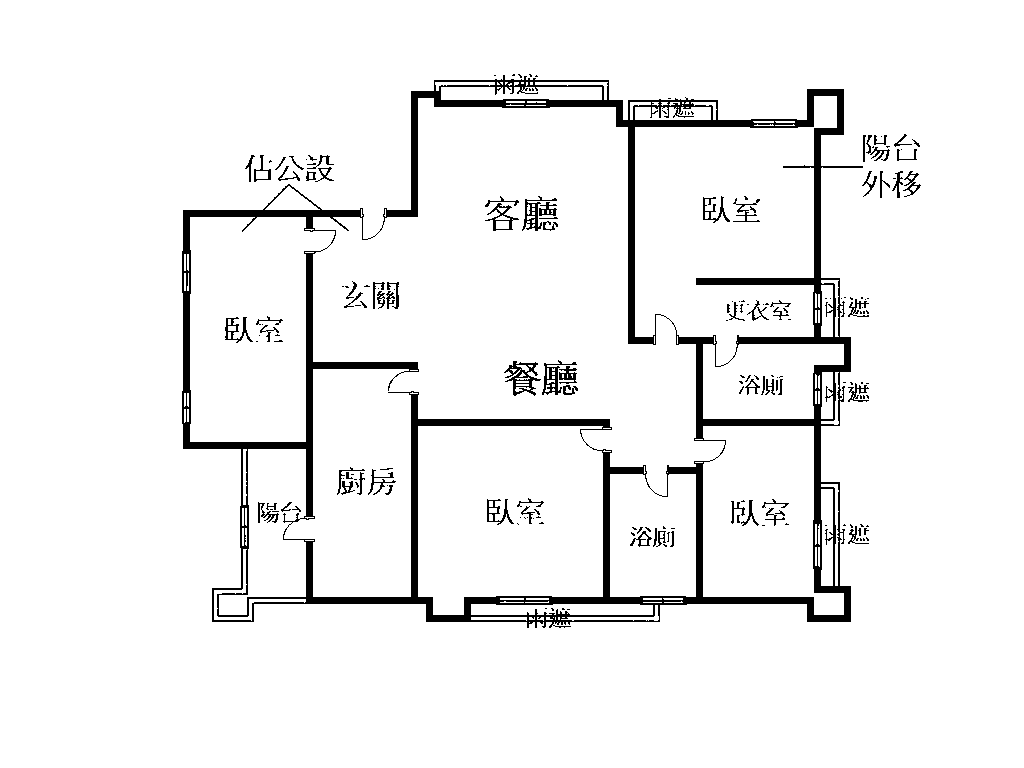

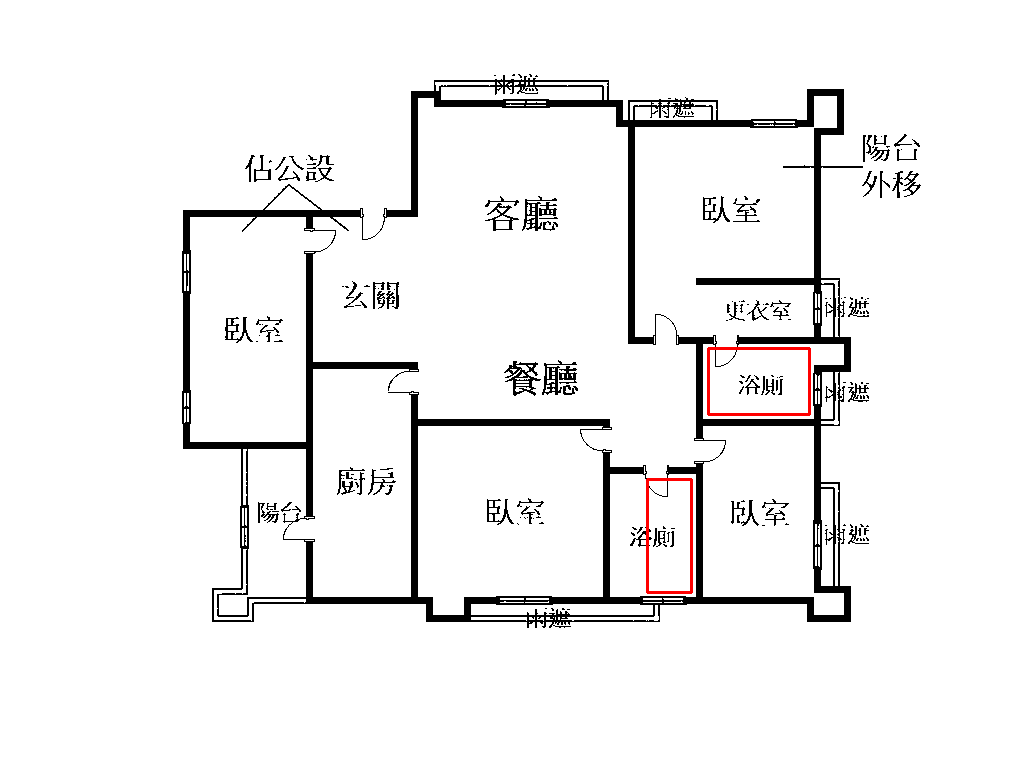

In [19]:
test2 = img.copy()
display(Image.fromarray(test2))
test2 = cv2.polylines(test2,bath_rectangle,True, (255, 0, 0), 2)
display(Image.fromarray(test2))

## Paintintg Center Point

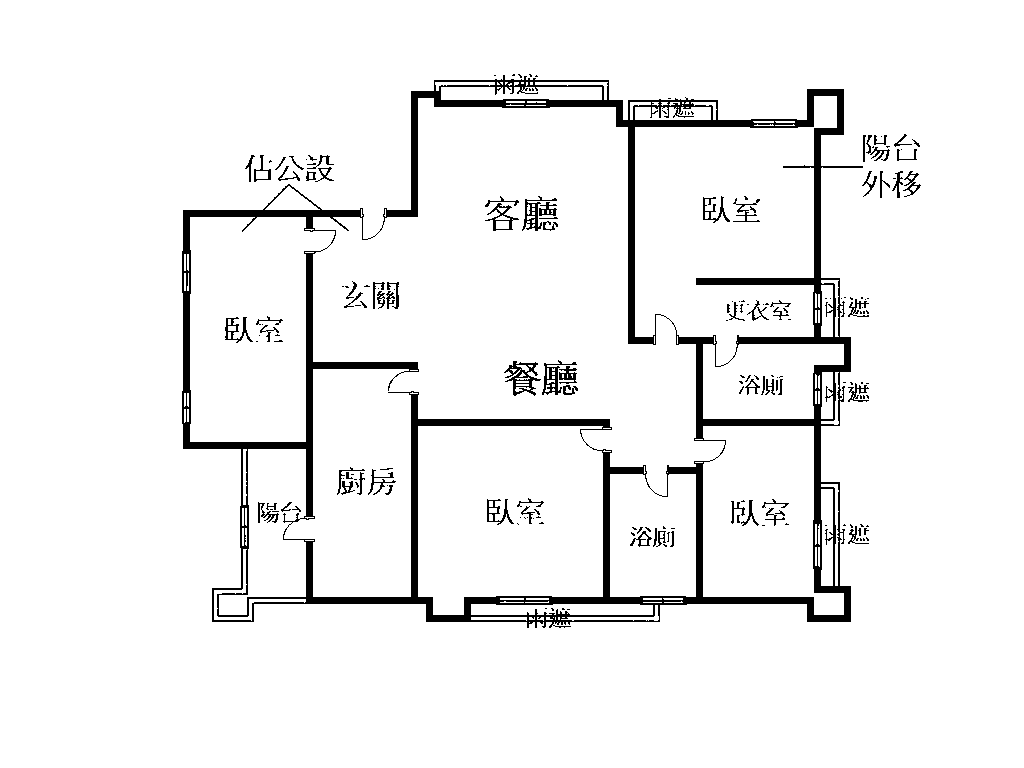

In [20]:
test3 = img.copy()
display(Image.fromarray(test3))

In [21]:
def center_point(test3):
    # Create blank imag
    height, width, channels = test3.shape
    blank_image = np.zeros((height,width,3), np.uint8)

    # Grayscale image
    gray = cv2.cvtColor(test3,cv2.COLOR_BGR2GRAY)

    # detect outer Contours (simple floor or roof solution), paint them red on blank_image
    contour, test3 = detect.detectOuterContours(gray, blank_image, color=(255,0,0))
    c = contour
    mv = cv2.moments(c)
    center_x = int(mv['m10']/mv['m00'])
    center_y = int(mv['m01']/mv['m00'])
    center_point = (center_x,center_y)
    
    return center_point #(center_x,center_y)

In [22]:
center_point = center_point(test2)
center_point

(533, 366)

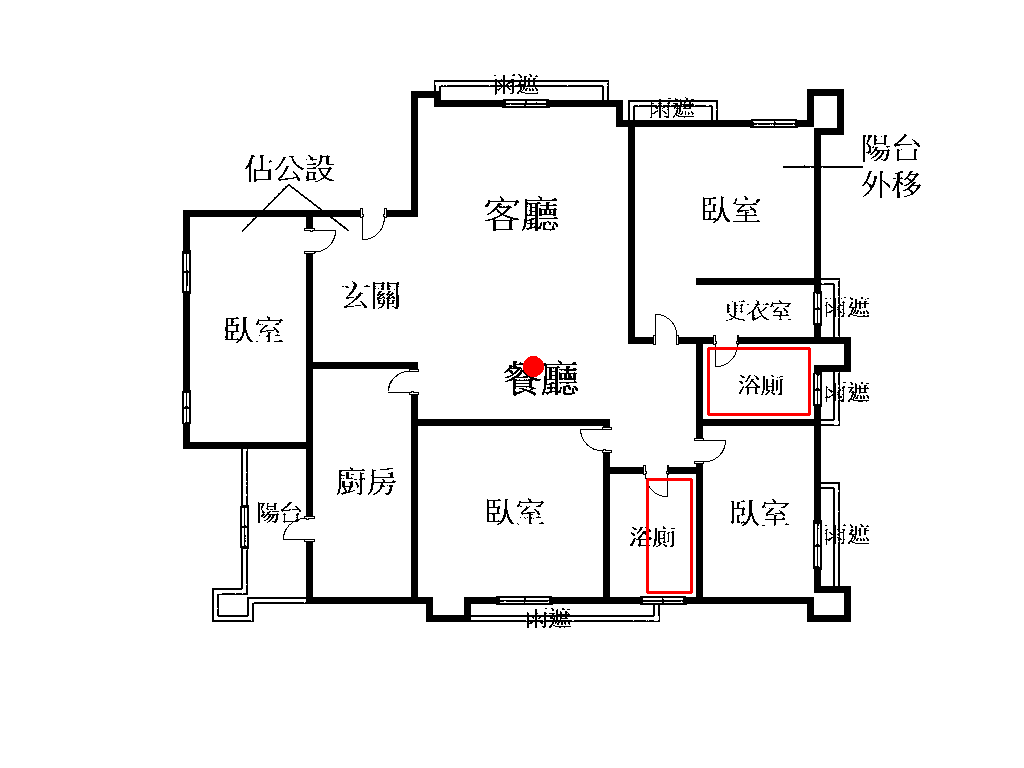

In [23]:
paint_center_point = cv2.circle(test2,center_point,10,(255,0,0),-1,0)
# Display
display(Image.fromarray(paint_center_point))

## Check fengshui

In [24]:
bath_rectangle

array([[[[647, 479],
         [647, 592],
         [691, 592],
         [691, 479]]],


       [[[708, 348],
         [708, 414],
         [809, 414],
         [809, 348]]]])

In [25]:
center_point

(533, 366)

In [26]:
# Check fengshui
for i in bath_rectangle:
    a = cv2.pointPolygonTest(i, center_point, False)
    if a == 1.0:
        print("浴廁居中")
        
    elif a == 0.0:
        print("浴廁居中")
        
    elif a == -1.0:
        print("浴廁並無居中")

浴廁並無居中
浴廁並無居中
